## PixelCNN Training
<br>
STEPS
0. Prepare CIFAR10 datasets and pretrained VQVAE
1. Input CIFAR10 Images to the encoder of VQVAE 
2. Extract Z(encoding vectors) and indices of embedding vectors that correspond to Z_enc
3. Make dataset for PixelCNN training using data extracted above
4. Train PixelCNN
5. Sample embeddings using trained PixelCNN and generate images by inputting those embeddings to the decoder of VQVAE
6. Visualize

In [1]:
import numpy as np
import torch, torchvision, os, argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable
from utils.data import data_loader
from utils.model_cifar10 import MODEL_CIFAR10
from utils.model_pixelcnn import PIXELCNN

STEP 1 : Prepare CIFAR10 datasets and pretrained VQVAE

In [2]:
k_dim = 64
z_dim = 64
kernel_size = 3
fm = 64
batch_size = 100
max_epoch = 30
lr = 1e-3
data_dir = 'data'
train_dataset = 'CIFAR10'
test_dataset = 'CIFAR10_test'
ckpt_dir = os.path.join('checkpoints','cifar10_z64_k64')

train_data_args = argparse.Namespace(**{'batch_size':batch_size,'data_dir':data_dir,'dataset':train_dataset})
train_data, train_loader = data_loader(train_data_args)

test_data_args = argparse.Namespace(**{'batch_size':batch_size,'data_dir':data_dir,'dataset':test_dataset})
test_data, test_loader = data_loader(test_data_args)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def load_checkpoint(ckpt_dir,model):
    filename = 'checkpoint.pth.tar'
    file_path = os.path.join(ckpt_dir,filename)
    if os.path.isfile(file_path):
        print("=> loading checkpoint '{}'".format(file_path))
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (iter {})"
              .format(filename, checkpoint['iter']))
    else:
        print("=> no checkpoint found at '{}'".format(file_path))
        
model_vqvae = MODEL_CIFAR10(k_dim=k_dim,z_dim=z_dim).cuda()
model_vqvae.eval()
load_checkpoint(ckpt_dir,model_vqvae)

=> loading checkpoint 'checkpoints/cifar10_z64_k64/checkpoint.pth.tar'
=> loaded checkpoint 'checkpoint.pth.tar' (iter 20000)


STEP 2 : Input CIFAR10 Images to the encoder of VQVAE
<br>
STEP 3 : Extract Z(encoding vectors) and indices of embedding vectors that correspond to Z_enc

In [4]:
criterion = F.cross_entropy

pixelcnn_dsets = dict()
pixelcnn_dsets['Z'] = []
pixelcnn_dsets['index'] = []
for batch_idx, (X,_) in enumerate(train_loader):
    X = Variable(X).cuda()
    Z_enc, embd_index = model_vqvae.forward_pixel_cnn(X)
    pixelcnn_dsets['Z'].append(Z_enc.data)
    pixelcnn_dsets['index'].append(embd_index.view(Z_enc.size(0),Z_enc.size(2),Z_enc.size(3)).data)
    
pixelcnn_dsets['Z'] = torch.cat(pixelcnn_dsets['Z'],0)
pixelcnn_dsets['index'] = torch.cat(pixelcnn_dsets['index'],0)

STEP 4 : Make dataset for PixelCNN training using data extracted above

In [5]:
import torch.utils.data as data
from torch.utils.data import DataLoader

class pixel_dset(data.Dataset):
    def __init__(self, pixelcnn_dsets):
        self.data = pixelcnn_dsets['Z']
        self.labels = pixelcnn_dsets['index']

    def __getitem__(self, index):
        img, target = self.data[index], self.labels[index]
        return img, target

    def __len__(self):
        return len(self.data)
    
new_loader = DataLoader(pixel_dset(pixelcnn_dsets),batch_size=batch_size)

print('Done!')

Done!


STEP 5 : Train PixelCNN

In [6]:
pixelcnn = PIXELCNN(k_dim=k_dim,z_dim=z_dim,kernel_size=kernel_size,fm=fm).cuda()
optimizer = optim.Adam(pixelcnn.parameters(),lr=lr,betas=(0.5,0.999))
pixelcnn.train()
for e in range(max_epoch):
    for batch_idx, (Z,index) in enumerate(new_loader):
        Z = Variable(Z).cuda()
        index = Variable(index).cuda()
        logits = pixelcnn(Z)
        loss = criterion(logits,index)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(e,loss)

print('Training PixelCNN is finished!')

0 Variable containing:
 2.1249
[torch.cuda.FloatTensor of size 1 (GPU 0)]

1 Variable containing:
 1.8629
[torch.cuda.FloatTensor of size 1 (GPU 0)]

2 Variable containing:
 1.6927
[torch.cuda.FloatTensor of size 1 (GPU 0)]

3 Variable containing:
 1.6016
[torch.cuda.FloatTensor of size 1 (GPU 0)]

4 Variable containing:
 1.5433
[torch.cuda.FloatTensor of size 1 (GPU 0)]

5 Variable containing:
 1.5011
[torch.cuda.FloatTensor of size 1 (GPU 0)]

6 Variable containing:
 1.4686
[torch.cuda.FloatTensor of size 1 (GPU 0)]

7 Variable containing:
 1.4429
[torch.cuda.FloatTensor of size 1 (GPU 0)]

8 Variable containing:
 1.4206
[torch.cuda.FloatTensor of size 1 (GPU 0)]

9 Variable containing:
 1.4029
[torch.cuda.FloatTensor of size 1 (GPU 0)]

10 Variable containing:
 1.3880
[torch.cuda.FloatTensor of size 1 (GPU 0)]

11 Variable containing:
 1.3743
[torch.cuda.FloatTensor of size 1 (GPU 0)]

12 Variable containing:
 1.3635
[torch.cuda.FloatTensor of size 1 (GPU 0)]

13 Variable containing

STEP 5 : Sample embeddings using trained PixelCNN and generate images by inputting those embeddings to the decoder of VQVAE
<br>
STEP 6 : Visualize

In [7]:
def show_batch_images(images,nrow=10,padding=5,pad_value=-1,**kwargs):
    grid=torchvision.utils.make_grid(images,nrow=10,padding=5,pad_value=-1,**kwargs)
    grid = (grid+1)/2
    plt.imshow(grid.permute(1,2,0).cpu().numpy())
    plt.show()

[ Random Z -> PixelCNN -> Embedding -> Decoder -> Generated Images]

[ Random Z -> PixelCNN -> Embedding -> Decoder -> Generated Images]


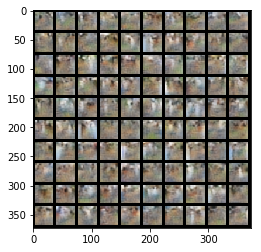

In [15]:
pixelcnn.eval()

_ , _, Z_w, Z_h = Z_enc.size()
rand_idx = Variable(torch.multinomial(torch.rand(batch_size*Z_w*Z_h,z_dim),1)).squeeze().long().cuda()
rand_Z = model_vqvae._modules['embd'].weight[rand_idx].view(-1,Z_w,Z_h,z_dim).permute(0,3,1,2)
starting_point = 3,0

for i in range(Z_w):
    for j in range(Z_h):
        if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                continue
        logit = pixelcnn(rand_Z.detach())
        prob = F.softmax(logit).data
        idx = torch.multinomial(prob[:,:,i,j],1).squeeze()
        rand_Z[:,:,i,j] = model_vqvae._modules['embd'].weight[idx]

sample = model_vqvae.decode(rand_Z)
print('[ Random Z -> PixelCNN -> Embedding -> Decoder -> Generated Images]')
show_batch_images(sample.data)

STEP 7 : 

In [9]:
X = iter(test_loader).next()[0]
X = Variable(X.cuda())
X_recon = model_vqvae(X)[0]

pixelcnn.eval()
Z_enc = model_vqvae.forward_pixel_cnn(X)[0]
Z_w = Z_enc.size(-1)
logit = pixelcnn(Z_enc)
prob = F.softmax(logit).permute(0,2,3,1).contiguous()
sample_idx = torch.multinomial(prob.view(-1,k_dim),1).squeeze()
sample_z = model_vqvae._modules['embd'].weight[sample_idx].view(-1,Z_w,Z_w,z_dim).permute(0,3,1,2)
sample = model_vqvae.decode(sample_z)

[Test Images]


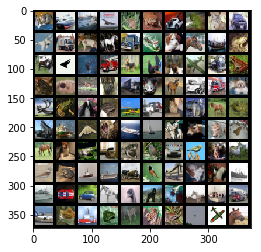

[Test Images -> encoder -> Z -> embedding -> decoder -> Reconstructed Images]


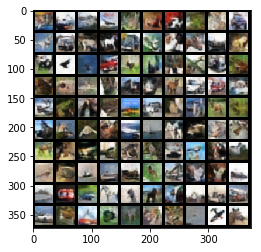

[Test Images -> encoder -> Z -> PixelCNN -> embedding -> decoder -> Generated Images]


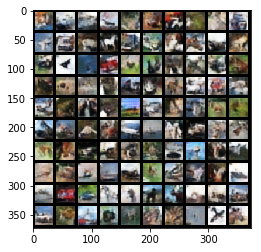

[Difference between Reconstructions and Generated Images]


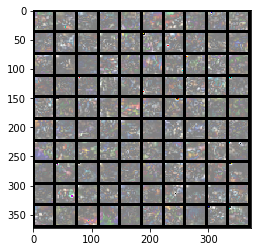

In [10]:
print('[Test Images]')
show_batch_images(X.data)
print('[Test Images -> encoder -> Z -> embedding -> decoder -> Reconstructed Images]')
show_batch_images(X_recon.data)
print('[Test Images -> encoder -> Z -> PixelCNN -> embedding -> decoder -> Generated Images]')
show_batch_images(sample.data)
print('[Difference between Reconstructions and Generated Images]')
show_batch_images((sample-X_recon).abs().data)